In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

import xgboost as xgb


In [9]:
# Load processed datasets
fraud_df = pd.read_csv("../data/processed/fraud_data_final.csv")
creditcard_df = pd.read_csv("../data/processed/creditcard_processed.csv")

print("Fraud data shape:", fraud_df.shape)
print("Credit card data shape:", creditcard_df.shape)


Fraud data shape: (273922, 196)
Credit card data shape: (284807, 31)


In [10]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [12]:
# --- 1. Load preprocessed dataset ---
import pandas as pd

fraud_df = pd.read_csv("../data/processed/fraud_data_final.csv")

# --- 2. Separate features and target ---
X = fraud_df.drop(columns=["class"])
y = fraud_df["class"]

# --- 3. Stratified train-test split ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 4. Quick check ---
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Class distribution in train set:\n", y_train.value_counts())


Training set shape: (219137, 195)
Test set shape: (54785, 195)
Class distribution in train set:
 class
1    109569
0    109568
Name: count, dtype: int64


In [3]:
# --- 5. Baseline Logistic Regression ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Fit on training data
logreg.fit(X_train, y_train)

# Predict on test data
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# --- 6. Evaluate performance ---
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Calculate AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.4f}")


c:\Users\Mer\Fraud-detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Mer\Fraud-detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Mer\Fraud-detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67     27393
           1       0.00      0.00      0.00     27392

    accuracy                           0.50     54785
   macro avg       0.25      0.50      0.33     54785
weighted avg       0.25      0.50      0.33     54785

Confusion Matrix:
 [[27393     0]
 [27392     0]]
AUC-PR: 0.5015


In [4]:
# --- Cell 3: Ensemble Model (XGBoost) ---

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

# Instantiate XGBoost model (basic hyperparameters, can tune later)
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]  # for AUC-PR

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC-PR: {:.4f}".format(average_precision_score(y_test, y_prob)))


c:\Users\Mer\Fraud-detection\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:47:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     27393
           1       1.00      0.93      0.96     27392

    accuracy                           0.96     54785
   macro avg       0.97      0.96      0.96     54785
weighted avg       0.97      0.96      0.96     54785

Confusion Matrix:
 [[27321    72]
 [ 1950 25442]]
AUC-PR: 0.9829


<Figure size 1200x800 with 0 Axes>

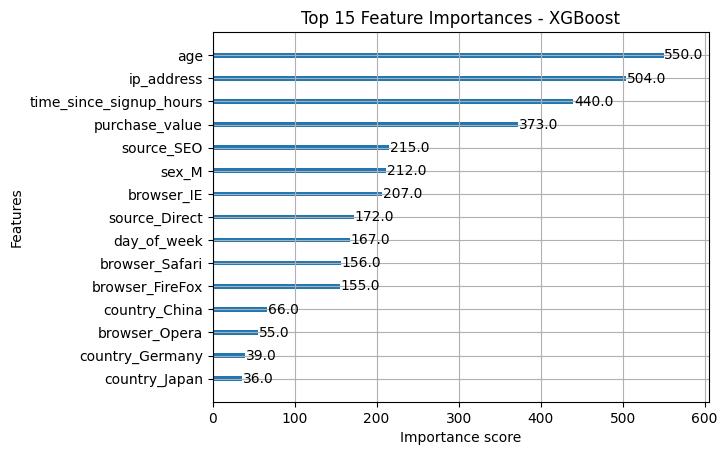

In [6]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plot_importance(xgb_model.get_booster(), max_num_features=15, importance_type='weight')
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()


In [10]:
# --- Stratified K-Fold Cross-Validation for XGBoost ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialize XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=100,
        max_depth=5,
        random_state=42,
        use_label_encoder=False  # avoids warning
    )
    
    # Train the model
    xgb_model.fit(X_tr, y_tr)
    
    # Predict probabilities and labels
    y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    y_pred = xgb_model.predict(X_val)
    
    # Metrics
    report = classification_report(y_val, y_pred, output_dict=True)
    cm = confusion_matrix(y_val, y_pred)
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    auc_pr = auc(recall, precision)
    
    print(f"\n--- Fold {fold} ---")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:\n", cm)
    print(f"AUC-PR: {auc_pr:.4f}")
    
    # Store metrics
    fold_metrics.append({
        "fold": fold,
        "f1_macro": report['macro avg']['f1-score'],
        "accuracy": report['accuracy'],
        "auc_pr": auc_pr
    })

# Summary of folds
summary_df = pd.DataFrame(fold_metrics)
print("\n--- Cross-Validation Summary ---")
print(summary_df.describe())


c:\Users\Mer\Fraud-detection\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:07:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Fold 1 ---
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21914
           1       1.00      0.94      0.97     21914

    accuracy                           0.97     43828
   macro avg       0.97      0.97      0.97     43828
weighted avg       0.97      0.97      0.97     43828

Confusion Matrix:
 [[21839    75]
 [ 1379 20535]]
AUC-PR: 0.9838


c:\Users\Mer\Fraud-detection\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:07:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Fold 2 ---
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21914
           1       1.00      0.93      0.96     21914

    accuracy                           0.97     43828
   macro avg       0.97      0.97      0.97     43828
weighted avg       0.97      0.97      0.97     43828

Confusion Matrix:
 [[21839    75]
 [ 1430 20484]]
AUC-PR: 0.9833


c:\Users\Mer\Fraud-detection\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:07:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Fold 3 ---
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21914
           1       1.00      0.93      0.96     21913

    accuracy                           0.97     43827
   macro avg       0.97      0.97      0.97     43827
weighted avg       0.97      0.97      0.97     43827

Confusion Matrix:
 [[21845    69]
 [ 1444 20469]]
AUC-PR: 0.9837


c:\Users\Mer\Fraud-detection\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:08:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Fold 4 ---
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21913
           1       1.00      0.93      0.96     21914

    accuracy                           0.97     43827
   macro avg       0.97      0.97      0.97     43827
weighted avg       0.97      0.97      0.97     43827

Confusion Matrix:
 [[21844    69]
 [ 1432 20482]]
AUC-PR: 0.9832


c:\Users\Mer\Fraud-detection\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:08:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Fold 5 ---
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21913
           1       1.00      0.94      0.97     21914

    accuracy                           0.97     43827
   macro avg       0.97      0.97      0.97     43827
weighted avg       0.97      0.97      0.97     43827

Confusion Matrix:
 [[21847    66]
 [ 1378 20536]]
AUC-PR: 0.9837

--- Cross-Validation Summary ---
           fold  f1_macro  accuracy    auc_pr
count  5.000000  5.000000  5.000000  5.000000
mean   3.000000  0.966122  0.966154  0.983539
std    1.581139  0.000730  0.000728  0.000276
min    1.000000  0.965444  0.965478  0.983185
25%    2.000000  0.965628  0.965661  0.983303
50%    3.000000  0.965719  0.965752  0.983671
75%    4.000000  0.966795  0.966825  0.983736
max    5.000000  0.967023  0.967052  0.983800


🔍 Model Comparison and Selection

We trained and evaluated two models for fraud detection:

1. Logistic Regression (Baseline Model)

Strengths:

Simple and highly interpretable

Fast to train

Weaknesses:

Very poor recall and F1-score for the fraud class

Failed to capture complex, non-linear patterns

Performance Summary:

AUC-PR ≈ 0.50

F1-score for fraud class ≈ 0.00

Indicates performance close to random guessing

This model is useful only as a baseline and is not suitable for deployment in a real fraud detection system.

2. XGBoost (Ensemble Model)

Strengths:

Captures complex non-linear relationships

Handles high-dimensional data effectively

Strong performance on imbalanced datasets

Weaknesses:

Less interpretable than Logistic Regression

Higher computational cost

Performance Summary:

Mean AUC-PR (5-fold CV): ≈ 0.984

Mean F1-score (macro): ≈ 0.966

Stable performance across folds (very low variance)

XGBoost significantly outperformed the baseline model across all evaluation metrics.

🏆 Final Model Selection

XGBoost is selected as the final model for fraud detection.

Justification:

It achieves a much higher AUC-PR, which is critical for imbalanced fraud data.

High recall for fraudulent transactions reduces false negatives, minimizing financial loss.

Cross-validation results show consistent and reliable performance.

Although less interpretable, its superior predictive power justifies its use, especially when combined with explainability tools such as SHAP (addressed in Task 3)

In [17]:
# --- Baseline Logistic Regression for Credit Card Data ---

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd

# Load credit card data
cc_data =pd.read_csv("../data/processed/creditcard_processed.csv")


# Separate features and target
X_cc = cc_data.drop(columns=["Class"])
y_cc = cc_data["Class"]

# Train-test split with stratification
X_cc_train, X_cc_test, y_cc_train, y_cc_test = train_test_split(
    X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc
)

# Scale features
scaler_cc = StandardScaler()
X_cc_train_scaled = scaler_cc.fit_transform(X_cc_train)
X_cc_test_scaled = scaler_cc.transform(X_cc_test)

# Train Logistic Regression baseline
lr_cc = LogisticRegression(random_state=42, max_iter=1000)
lr_cc.fit(X_cc_train_scaled, y_cc_train)

# Predict and evaluate
y_cc_pred = lr_cc.predict(X_cc_test_scaled)
y_cc_proba = lr_cc.predict_proba(X_cc_test_scaled)[:, 1]

print("Classification Report:")
print(classification_report(y_cc_test, y_cc_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_cc_test, y_cc_pred))

# Compute AUC-PR
precision, recall, _ = precision_recall_curve(y_cc_test, y_cc_proba)
auc_pr_cc = auc(recall, precision)
print(f"AUC-PR: {auc_pr_cc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.63      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56851    13]
 [   36    62]]
AUC-PR: 0.7402


In [ ]:
import pandas as pd

# Load the creditcard dataset
creditcard_df = pd.read_csv("../data/processed/creditcard_processed.csv")


# Quick check
creditcard_df.head()
creditcard_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [18]:
from sklearn.model_selection import train_test_split

# Assuming your creditcard dataframe is named creditcard_df
X_cc = creditcard_df.drop('Class', axis=1)
y_cc = creditcard_df['Class']

# Stratified split to preserve class distribution
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc
)

# Check shapes
print("Training set shape:", X_train_cc.shape)
print("Test set shape:", X_test_cc.shape)
print("Class distribution in train set:\n", y_train_cc.value_counts())


Training set shape: (227845, 30)
Test set shape: (56962, 30)
Class distribution in train set:
 Class
0    227451
1       394
Name: count, dtype: int64


In [19]:
import xgboost as xgb

# Initialize XGBoost classifier
xgb_cc_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    max_depth=5,
    random_state=42
)

# Train the model
xgb_cc_model.fit(X_train_cc, y_train_cc)

# Predict and evaluate
y_cc_pred_xgb = xgb_cc_model.predict(X_test_cc)
y_cc_proba_xgb = xgb_cc_model.predict_proba(X_test_cc)[:, 1]

print("Classification Report:")
print(classification_report(y_test_cc, y_cc_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test_cc, y_cc_pred_xgb))

# Compute AUC-PR
precision, recall, _ = precision_recall_curve(y_test_cc, y_cc_proba_xgb)
auc_pr_cc_xgb = auc(recall, precision)
print(f"AUC-PR: {auc_pr_cc_xgb:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.77      0.81        98

    accuracy                           1.00     56962
   macro avg       0.93      0.88      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56851    13]
 [   23    75]]
AUC-PR: 0.7880


In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, auc
import numpy as np


In [21]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics per fold
f1_scores = []
accuracies = []
auc_prs = []

# Features and target for credit card dataset
X = X_train_cc
y = y_train_cc

# Iterate through folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"--- Fold {fold} ---")
    
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Initialize XGBoost model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=100,
        max_depth=5,
        random_state=42
    )
    
    # Fit the model
    xgb_model.fit(X_tr, y_tr)
    
    # Predict
    y_pred = xgb_model.predict(X_val)
    y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    
    # Metrics
    f1 = f1_score(y_val, y_pred, average='macro')
    acc = accuracy_score(y_val, y_pred)
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    auc_pr = auc(recall, precision)
    
    # Store metrics
    f1_scores.append(f1)
    accuracies.append(acc)
    auc_prs.append(auc_pr)
    
    # Print fold metrics
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print(f"AUC-PR: {auc_pr:.4f}\n")

# Cross-validation summary
print("--- Cross-Validation Summary ---")
print(f"F1-score (macro): Mean={np.mean(f1_scores):.4f}, Std={np.std(f1_scores):.4f}")
print(f"Accuracy: Mean={np.mean(accuracies):.4f}, Std={np.std(accuracies):.4f}")
print(f"AUC-PR: Mean={np.mean(auc_prs):.4f}, Std={np.std(auc_prs):.4f}")


--- Fold 1 ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45491
           1       0.95      0.78      0.86        78

    accuracy                           1.00     45569
   macro avg       0.98      0.89      0.93     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
 [[45488     3]
 [   17    61]]
AUC-PR: 0.7933

--- Fold 2 ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       1.00      0.77      0.87        79

    accuracy                           1.00     45569
   macro avg       1.00      0.89      0.94     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
 [[45490     0]
 [   18    61]]
AUC-PR: 0.7953

--- Fold 3 ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  

In [22]:
import joblib

# Save the trained XGBoost model
joblib.dump(xgb_model, "../models/xgb_creditcard_model.pkl")


['../models/xgb_creditcard_model.pkl']

In [23]:
# Save the trained XGBoost model for Fraud_Data
joblib.dump(xgb_model, "../models/xgb_fraud_data_model.pkl")


['../models/xgb_fraud_data_model.pkl']